In [0]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from google.colab import files

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.legend_handler import HandlerLine2D

import numpy as np

**LOAD DATA**

Load data through google drive link


Download and setup photo data

In [0]:
def setData():
  !mkdir data/

  !wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1HzZBLsKi99RokCF-qLQeA9--L7XnVP5B' -O data/train.zip
  !wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1U0UE6gjmspQkVea8xOm3CT-wKsbBAwzF' -O data/addsucc.zip
  !wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=15rYkZ-tH4owzg-1yb2Ie1de3lQomhQ5X' -O data/addon_desk.zip
  !wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1IpaIM1K0cdeQTk_m_lLirjbVGZJTHRVA' -O data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

  !mkdir data/train
  !unzip data/train.zip -d data/train/
  !unzip data/addsucc.zip -d data/train/train/succ/
  !unzip data/addon_desk.zip -d data/train/train/zon_desk/



Download and setup simulation data

In [0]:
def setSimData():
  !wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=16TyVfg-CWPLr8wIA8VfzgAwWspvF2RIk' -O data/sim_succ.zip
  !wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1MRG2JlDXaRgsXnGGr5wYfcKDJJnxzFR5' -O data/sim_desk.zip

  !unzip data/sim_succ.zip -d data/train/train/succ
  !unzip data/sim_desk.zip -d data/train/train/zon_desk


Models

In [0]:
def model_inceptionV3(pixel):
  pre_trained_model = InceptionV3(
      input_shape=(pixel, pixel, 3), include_top=False, weights='imagenet')
  
  for layer in pre_trained_model.layers:
    layer.trainable = False
  last_layer = pre_trained_model.get_layer('mixed7')
  #print('last layer output shape:', last_layer.output_shape)
  last_output = last_layer.output

  return last_output, pre_trained_model

In [0]:
def model_inceptionResV2(pixel):
  pre=keras.applications.InceptionResNetV2(include_top=False, input_shape=(pixel,pixel,3), weights='imagenet')

  for layer in pre.layers:
    layer.trainable=False
  last_layer= pre.get_layer('mixed_7a')
  last_output=last_layer.output

  return last_output, pre

Add layer to the pre trained model


In [0]:
def configureLayers(last_output, pre_trained_model):

  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)
  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation='sigmoid')(x)
  
  model = Model(pre_trained_model.input, x)
  model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])
  return model

Create model

In [0]:
def create_model(mod, pixel):
  last_output, pre_trained_model=  mod(pixel)
  return configureLayers(last_output,pre_trained_model)

**Image Processing**

Transform image to the given size array.

Add data-augmentation. Augmented data will be applied randomly in each epoch.

In [0]:
def generator(trainpath, validpath, pixels):
  train_dir = trainpath
  valid_dir=validpath

  train_datagens=[]

  val_datagen = ImageDataGenerator(rescale=1./255)
  train_datagens.append(val_datagen)

  # Add data-augmentation parameters to ImageDataGenerator
  train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

  
  train_generator=train_datagen.flow_from_directory(
      train_dir,
      target_size=(pixels,pixels),
      batch_size=20,
      class_mode='binary')

  valid_generator = val_datagen.flow_from_directory(
        valid_dir,
        target_size=(pixels, pixels),  
        batch_size=20,
        class_mode='binary')
  
  return train_generator, valid_generator

**Train Model**

Train model and draw a graph for accuracy and validation

In [0]:
def trainGraph(model, train_generator, valid_generator, epoch,cppath):
  #cp_callback = keras.callbacks.ModelCheckpoint(cppath+"/weights.{epoch:02d}.ckpt",
  #                                        save_weights_only=True,
  #                                        save_best_only=True,
  #                                        verbose=1)
  cp_callback = keras.callbacks.ModelCheckpoint(cppath+"/weights.{epoch:02d}.ckpt",
                                          save_weights_only=True,
                                          #save_best_only=True,
                                          #period=5,
                                          verbose=1)
  
  history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epoch,
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        callbacks=[cp_callback],
        verbose=2)



# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
  acc = history.history['acc']
  val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
  loss = history.history['loss']
  val_loss = history.history['val_loss']

# Get number of epochs
  epochs = range(len(acc))

# Plot training and validation accuracy per epoch
  train1,=plt.plot(epochs, acc)
  valid1, =plt.plot(epochs, val_acc)
  plt.title('Training and validation accuracy')

  plt.legend([(train1),(valid1)],['train','valid'])


  plt.figure()

# Plot training and validation loss per epoch
  train2,=plt.plot(epochs, loss)
  valid2,=plt.plot(epochs, val_loss)
  plt.title('Training and validation loss')

  plt.legend([(train2),(valid2)],['train','valid'])

In [0]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setup data and train

In [0]:
setData()

In [0]:
model= create_model(model_inceptionResV2, 350)

In [0]:
train_generator, valid_generator=generator('data/train/train/','data/train/valid',350)

In [0]:
!mkdir cp

Epoch 1/50

Epoch 00001: saving model to data/cp/150150/weights.01.ckpt
35/35 - 23s - loss: 1.6866 - acc: 0.7429 - val_loss: 0.6988 - val_acc: 0.6000
Epoch 2/50

Epoch 00002: saving model to data/cp/150150/weights.02.ckpt
35/35 - 22s - loss: 0.4997 - acc: 0.8014 - val_loss: 0.8018 - val_acc: 0.5920
Epoch 3/50

Epoch 00003: saving model to data/cp/150150/weights.03.ckpt
35/35 - 22s - loss: 0.4638 - acc: 0.8400 - val_loss: 0.7291 - val_acc: 0.5960
Epoch 4/50

Epoch 00004: saving model to data/cp/150150/weights.04.ckpt
35/35 - 21s - loss: 0.3494 - acc: 0.8471 - val_loss: 0.6894 - val_acc: 0.6120
Epoch 5/50

Epoch 00005: saving model to data/cp/150150/weights.05.ckpt
35/35 - 21s - loss: 0.2936 - acc: 0.8500 - val_loss: 0.7071 - val_acc: 0.5940
Epoch 6/50

Epoch 00006: saving model to data/cp/150150/weights.06.ckpt
35/35 - 22s - loss: 0.2830 - acc: 0.8586 - val_loss: 0.7228 - val_acc: 0.6080
Epoch 7/50

Epoch 00007: saving model to data/cp/150150/weights.07.ckpt
35/35 - 22s - loss: 0.5691 -

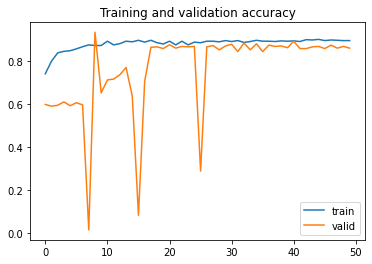

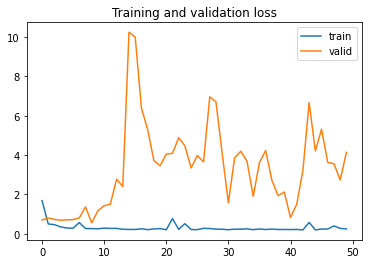

In [0]:
trainGraph(model,train_generator,valid_generator, 50, 'cp')

TEST

Download test data

In [0]:
def testset():
  !wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1_Y3puvQj4Ef6TCx3nj5FcPNnhj9y2sYr' -O data/testsucc.zip
  !wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1yhIuF0tRbcNnaHivrFa5fga4zsbTfWLt' -O data/testdesk.zip

  !mkdir test
  !mkdir test/test1
  !mkdir test/test2
  !mkdir data
  !unzip data/testsucc.zip -d test/test1/
  !unzip data/testdesk.zip -d test/test2/
  

In [0]:
testset()

Generate test image data generator

In [113]:

pixels=350
train1_datagen = ImageDataGenerator(
    rescale=1./255)


test_generator=train1_datagen.flow_from_directory(
      'test/test1',
      target_size=(pixels,pixels),
      batch_size=1,
      class_mode='binary')

test_generator2=train1_datagen.flow_from_directory(
      'test/test2',
      target_size=(pixels,pixels),
      batch_size=1,
      class_mode='binary')



Found 71 images belonging to 1 classes.
Found 72 images belonging to 1 classes.


Create a model

In [0]:
m2=create_model(model_inceptionV3,350)

In [0]:
m2=keras.models.load_model('drive/My Drive/files/model.h5')

Load weights

In [0]:
#m2.load_weights('drive/My Drive/cp/350350sim2/weights.25.ckpt')

In [0]:
predict_results=[]

In [129]:
count=0
for i in range(len(test_generator)):
  tmp=m2.predict(test_generator[i][0])
  predict_results.append(tmp[0][0])
  if tmp[0][0]<0.5:
    count+=1
print(count)
print(i+1)

69
71


In [130]:
count=0
for i in range(len(test_generator2)):
  tmp=m2.predict(test_generator2[i][0])
  predict_results.append(tmp[0][0])
  if tmp[0][0]>=0.5:
    count+=1
print(count)
print(i+1)

69
72


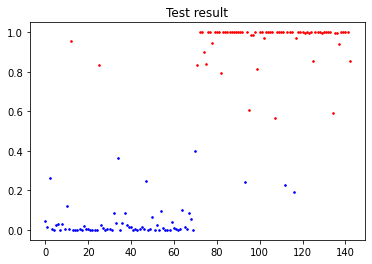

In [131]:
x=np.linspace(0,len(test_generator)+len(test_generator2)-1,len(test_generator)+len(test_generator2))
y= np.asarray(predict_results)
ne=np.ma.masked_where(y>=0.5,y)
po=np.ma.masked_where(y<0.5, y)
plt.title('Test result')
plt.plot(x,ne,'bo',x,po,'ro',markersize=1.6)